In [1]:
import glob
from scipy.io import loadmat
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('0hp_all_faults.csv')

In [3]:
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definicja parametrów
win_len = 784
stride = 300

# Inicjalizacja list dla danych wejściowych (X) i wyjściowych (Y)
X = []
Y = []

# Parametry do transformacji falkowej ciągłej (CWT)
widths = np.arange(1, 64) # Zakres skali
wavelet = morlet # Wybrana falka Morleta

# Pętla przez unikalne etykiety w kolumnie 'fault' ramki danych df
for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k] # Wybór wierszy odpowiadających danej etykiecie

    # Pętla przez ramkę danych z krokiem określonym przez parametr stride
    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values # Wybór okna danych
        temp = np.sum(temp, axis=1) # Sumowanie danych wzdłuż osi, pozostawiając jednowymiarowy sygnał
        
        # Przeprowadzenie CWT na każdej próbce
        cwt_data = cwt(temp, wavelet, widths)
        
        # Dostosowanie kształtu danych
        cwt_data = np.abs(cwt_data)

        X.append(cwt_data) # Dodanie danych wejściowych do listy X
        Y.append(df_temp_2.iloc[i + win_len, -1]) # Dodanie etykiety do listy Y

# Konwersja list X i Y na tablice numpy
X = np.array(X)
Y = np.array(Y)

# Kodowanie etykiet klas za pomocą LabelEncodera i przekształcenie ich na postać one-hot
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

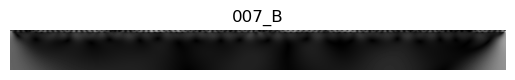

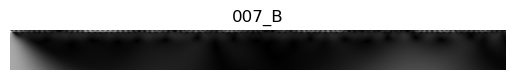

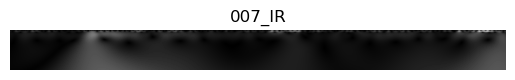

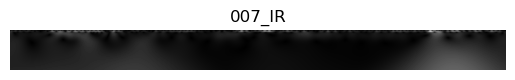

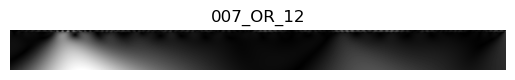

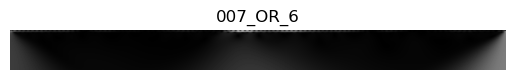

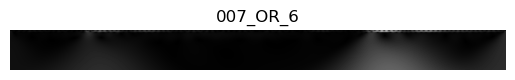

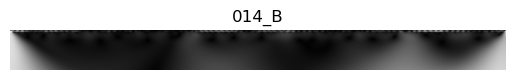

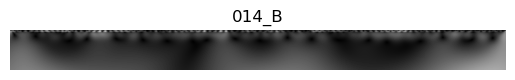

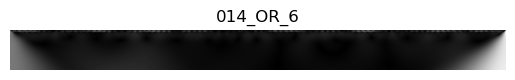

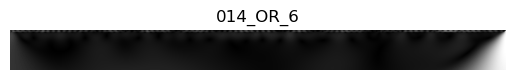

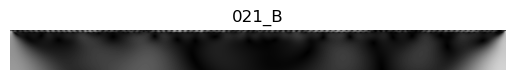

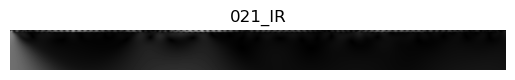

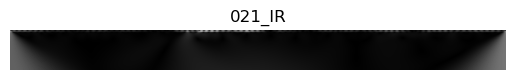

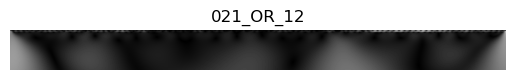

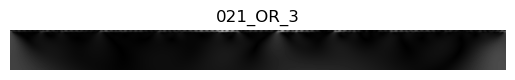

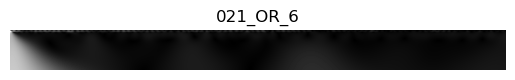

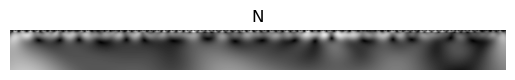

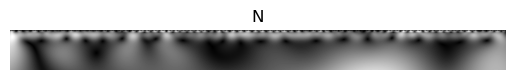

In [4]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [6]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(X.shape[1],X.shape[2],1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 59, 780, 6)        156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 390, 6)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 386, 16)       2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 193, 16)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 37056)             0         
                                                                 
 dense (Dense)               (None, 120)               4

In [8]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
17/17 [==============================] - 107s 6s/step - loss: 2.1608 - accuracy: 0.2478 - val_loss: 1.5309 - val_accuracy: 0.5963
Epoch 2/80
17/17 [==============================] - 96s 6s/step - loss: 1.1278 - accuracy: 0.6550 - val_loss: 0.8803 - val_accuracy: 0.7062
Epoch 3/80
17/17 [==============================] - 95s 6s/step - loss: 0.7392 - accuracy: 0.7463 - val_loss: 0.6953 - val_accuracy: 0.7578
Epoch 4/80
17/17 [==============================] - 96s 6s/step - loss: 0.5699 - accuracy: 0.8042 - val_loss: 0.5549 - val_accuracy: 0.8100
Epoch 5/80
17/17 [==============================] - 96s 6s/step - loss: 0.4653 - accuracy: 0.8410 - val_loss: 0.4672 - val_accuracy: 0.8353
Epoch 6/80
17/17 [==============================] - 97s 6s/step - loss: 0.4122 - accuracy: 0.8589 - val_loss: 0.4414 - val_accuracy: 0.8515
Epoch 7/80
17/17 [==============================] - 96s 6s/step - loss: 0.3546 - accuracy: 0.8813 - val_loss: 0.3610 - val_accuracy: 0.8836
Epoch 8/80
17/17 [=

87/87 [==============================] - 11s 123ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

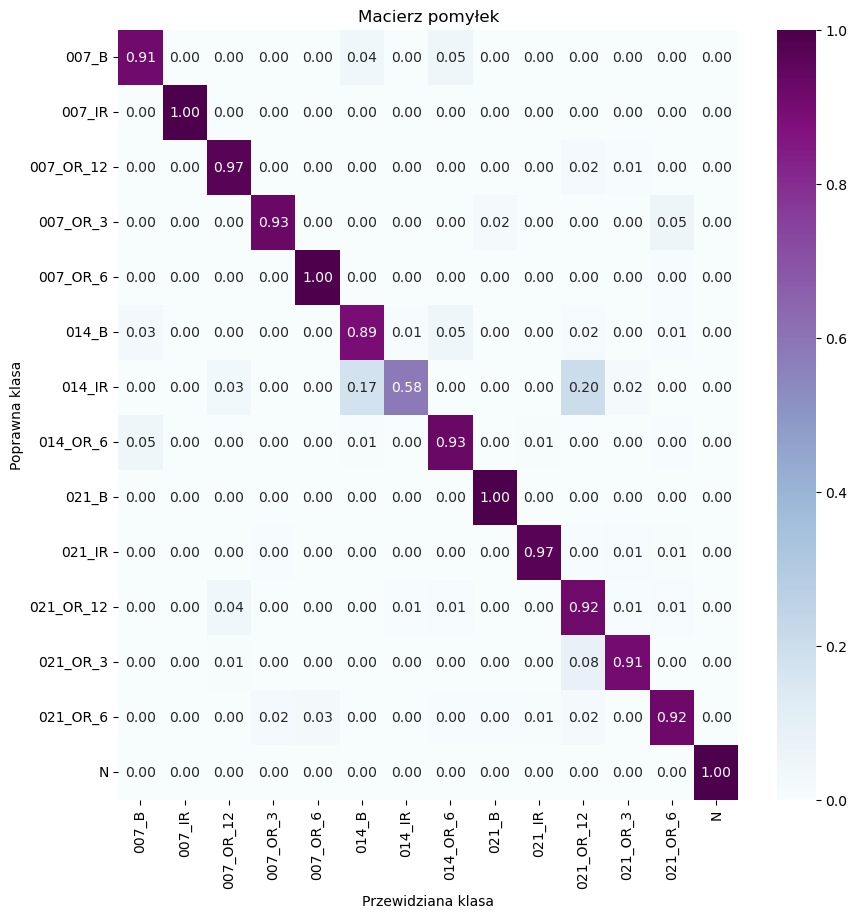

In [9]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [10]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9437635183850036


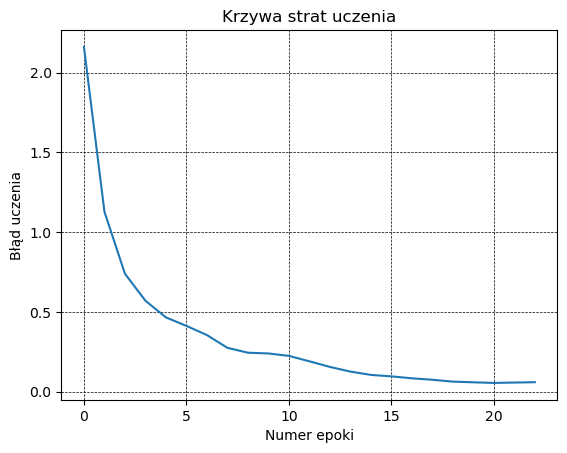

In [11]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

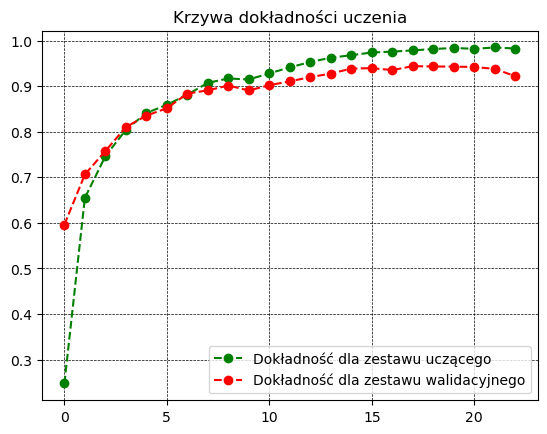

In [12]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

203/203 [==============================] - 25s 124ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.016s...
[t-SNE] Computed neighbors for 6472 samples in 0.894s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 5.757362
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.006577
[t-SNE] KL divergence after 300 iterations: 2.252057


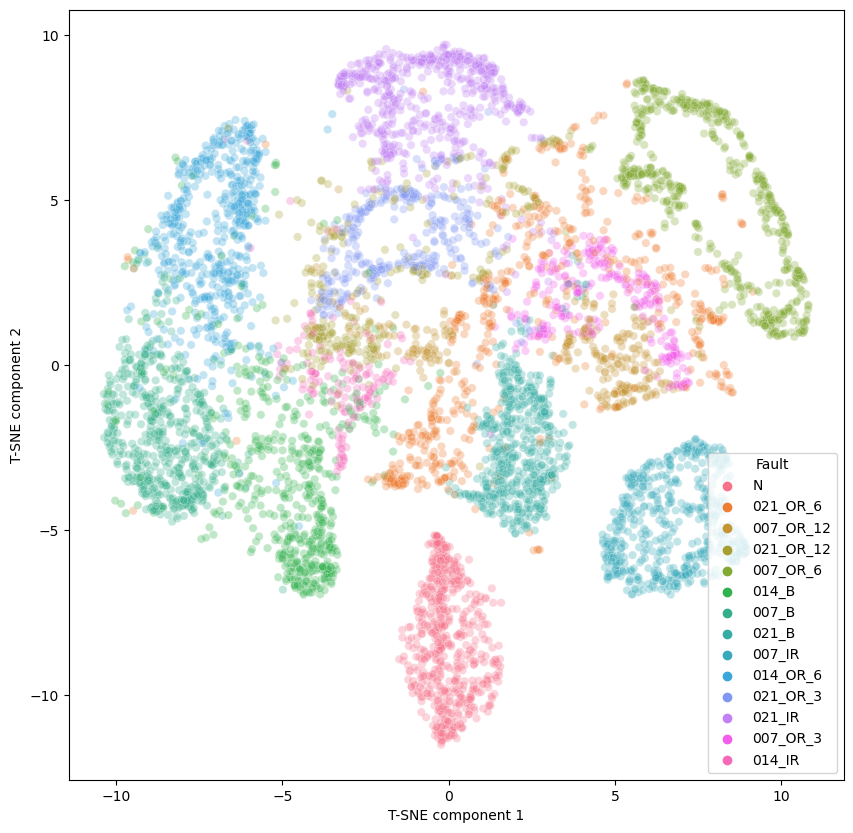

In [13]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [14]:
df = pd.read_csv('1hp_all_faults.csv')

In [15]:
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definicja parametrów
win_len = 784
stride = 300

# Inicjalizacja list dla danych wejściowych (X) i wyjściowych (Y)
X = []
Y = []

# Parametry do transformacji falkowej ciągłej (CWT)
widths = np.arange(1, 64) # Zakres skali
wavelet = morlet # Wybrana falka Morleta

# Pętla przez unikalne etykiety w kolumnie 'fault' ramki danych df
for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k] # Wybór wierszy odpowiadających danej etykiecie

    # Pętla przez ramkę danych z krokiem określonym przez parametr stride
    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values # Wybór okna danych
        temp = np.sum(temp, axis=1) # Sumowanie danych wzdłuż osi, pozostawiając jednowymiarowy sygnał
        
        # Przeprowadzenie CWT na każdej próbce
        cwt_data = cwt(temp, wavelet, widths)
        
        # Dostosowanie kształtu danych
        cwt_data = np.abs(cwt_data)

        X.append(cwt_data) # Dodanie danych wejściowych do listy X
        Y.append(df_temp_2.iloc[i + win_len, -1]) # Dodanie etykiety do listy Y

# Konwersja list X i Y na tablice numpy
X = np.array(X)
Y = np.array(Y)

# Kodowanie etykiet klas za pomocą LabelEncodera i przekształcenie ich na postać one-hot
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

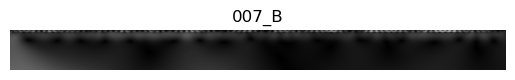

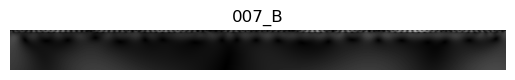

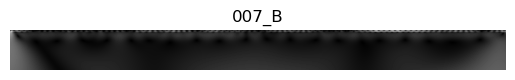

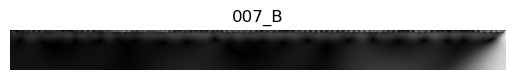

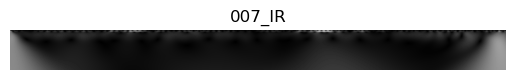

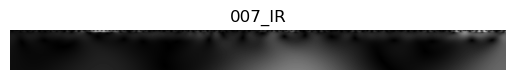

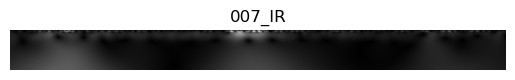

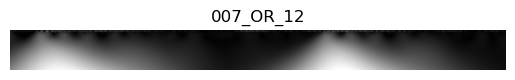

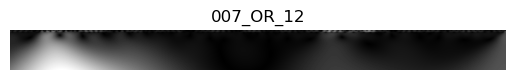

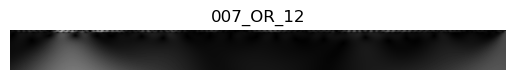

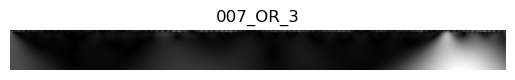

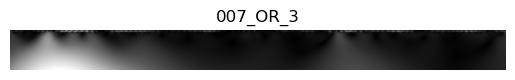

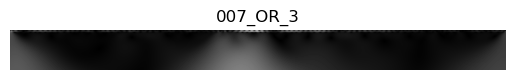

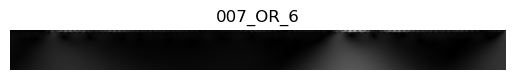

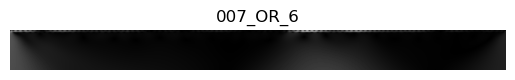

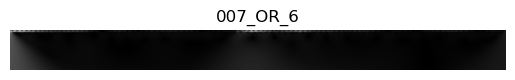

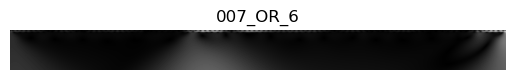

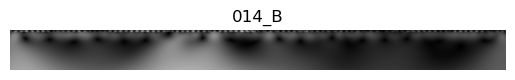

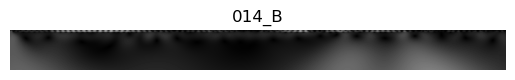

In [16]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [17]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [18]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu',  input_shape=(X.shape[1],X.shape[2],1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 59, 780, 6)        156       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 390, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 386, 16)       2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 193, 16)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 37056)             0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [20]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 255s 6s/step - loss: 1.5378 - accuracy: 0.4558 - val_loss: 1.0790 - val_accuracy: 0.6035
Epoch 2/80
40/40 [==============================] - 224s 6s/step - loss: 0.7118 - accuracy: 0.7425 - val_loss: 0.5432 - val_accuracy: 0.7955
Epoch 3/80
40/40 [==============================] - 220s 6s/step - loss: 0.4721 - accuracy: 0.8310 - val_loss: 0.5221 - val_accuracy: 0.8022
Epoch 4/80
40/40 [==============================] - 221s 6s/step - loss: 0.3806 - accuracy: 0.8637 - val_loss: 0.3474 - val_accuracy: 0.8642
Epoch 5/80
40/40 [==============================] - 229s 6s/step - loss: 0.2750 - accuracy: 0.9036 - val_loss: 0.3333 - val_accuracy: 0.8702
Epoch 6/80
40/40 [==============================] - 220s 6s/step - loss: 0.2457 - accuracy: 0.9124 - val_loss: 0.3262 - val_accuracy: 0.8678
Epoch 7/80
40/40 [==============================] - 219s 5s/step - loss: 0.2283 - accuracy: 0.9177 - val_loss: 0.3200 - val_accuracy: 0.8833
Epoch 8/80
40

210/210 [==============================] - 28s 132ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

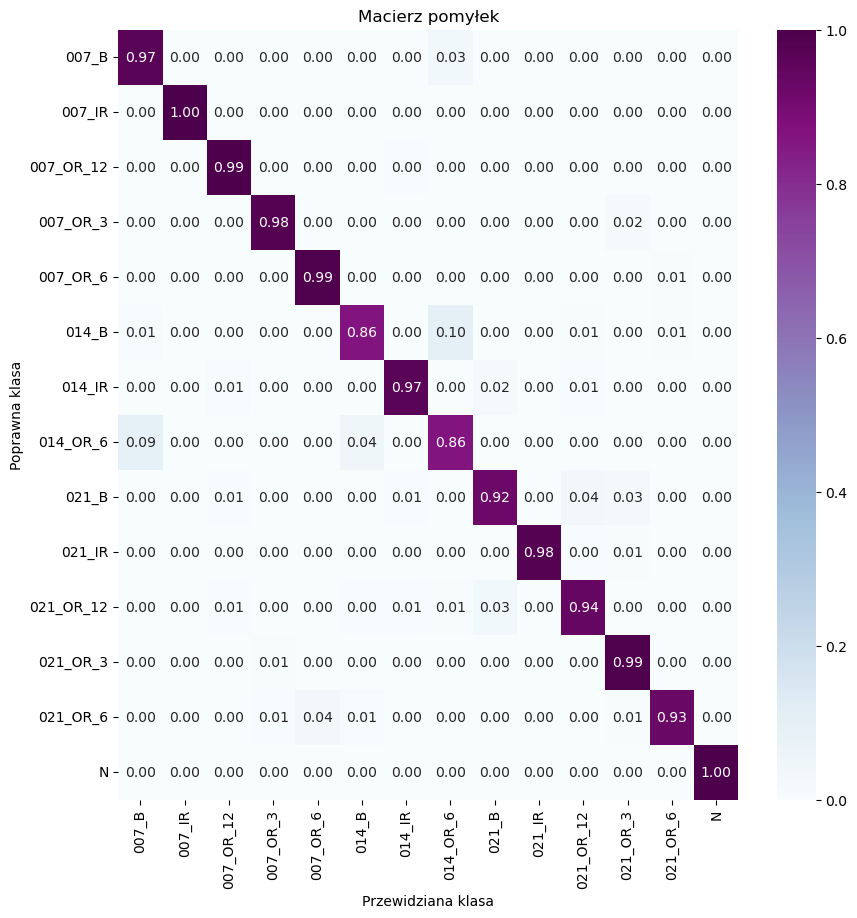

In [21]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [22]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9560800717060054


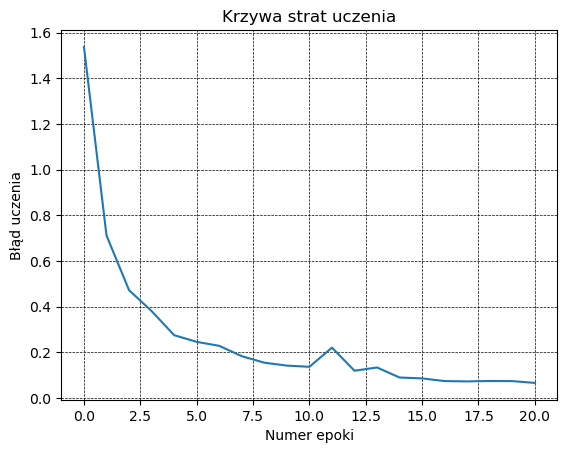

In [23]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

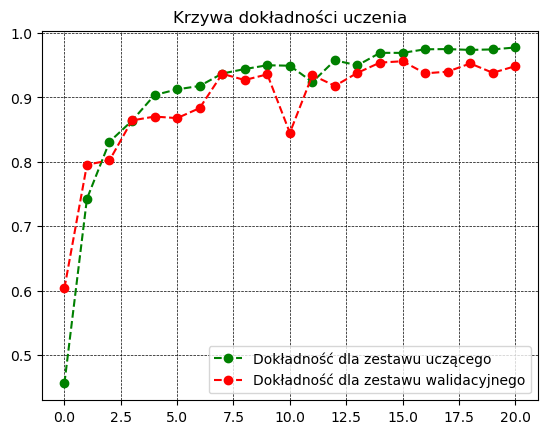

In [24]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

489/489 [==============================] - 64s 129ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15617 samples in 0.000s...
[t-SNE] Computed neighbors for 15617 samples in 2.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15617
[t-SNE] Computed conditional probabilities for sample 2000 / 15617
[t-SNE] Computed conditional probabilities for sample 3000 / 15617
[t-SNE] Computed conditional probabilities for sample 4000 / 15617
[t-SNE] Computed conditional probabilities for sample 5000 / 15617
[t-SNE] Computed conditional probabilities for sample 6000 / 15617
[t-SNE] Computed conditional probabilities for sample 7000 / 15617
[t-SNE] Computed conditional probabilities for sample 8000 / 15617
[t-SNE] Computed conditional probabilities for sample 9000 / 15617
[t-SNE] Computed conditional probabilities for sample 10000 / 15617
[t-SNE] Computed conditional probabilities for sample 11000 / 15617
[t-SNE] Computed conditional probabilities for sample 12000

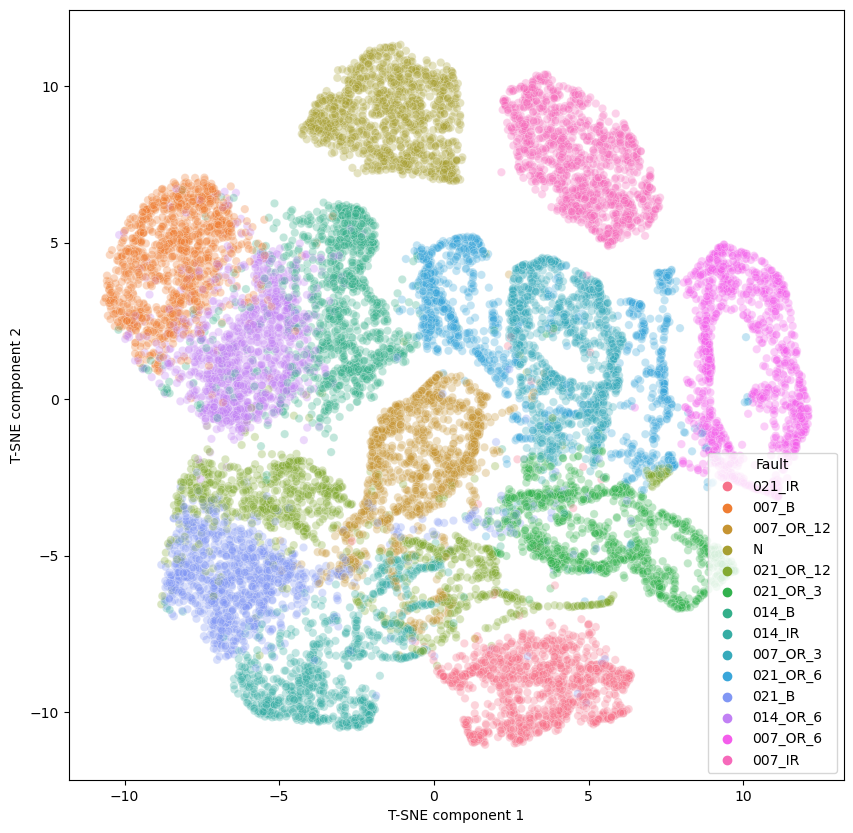

In [25]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [26]:
df = pd.read_csv('2hp_all_faults.csv')

In [27]:
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definicja parametrów
win_len = 784
stride = 300

# Inicjalizacja list dla danych wejściowych (X) i wyjściowych (Y)
X = []
Y = []

# Parametry do transformacji falkowej ciągłej (CWT)
widths = np.arange(1, 64) # Zakres skali
wavelet = morlet # Wybrana falka Morleta

# Pętla przez unikalne etykiety w kolumnie 'fault' ramki danych df
for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k] # Wybór wierszy odpowiadających danej etykiecie

    # Pętla przez ramkę danych z krokiem określonym przez parametr stride
    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values # Wybór okna danych
        temp = np.sum(temp, axis=1) # Sumowanie danych wzdłuż osi, pozostawiając jednowymiarowy sygnał
        
        # Przeprowadzenie CWT na każdej próbce
        cwt_data = cwt(temp, wavelet, widths)
        
        # Dostosowanie kształtu danych
        cwt_data = np.abs(cwt_data)

        X.append(cwt_data) # Dodanie danych wejściowych do listy X
        Y.append(df_temp_2.iloc[i + win_len, -1]) # Dodanie etykiety do listy Y

# Konwersja list X i Y na tablice numpy
X = np.array(X)
Y = np.array(Y)

# Kodowanie etykiet klas za pomocą LabelEncodera i przekształcenie ich na postać one-hot
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

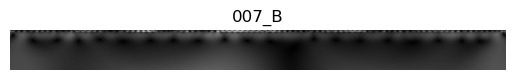

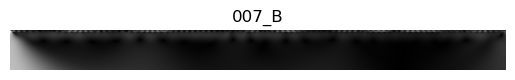

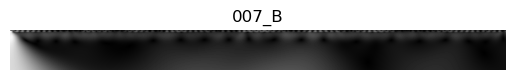

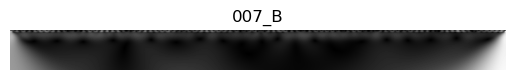

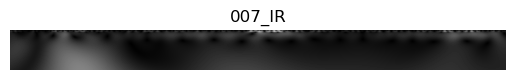

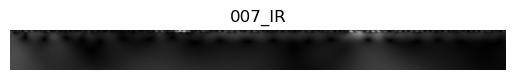

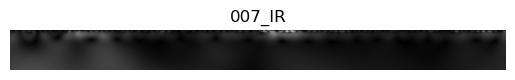

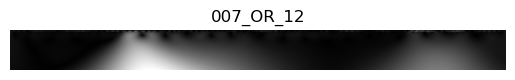

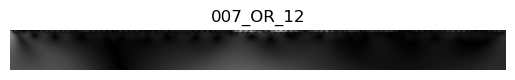

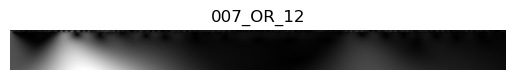

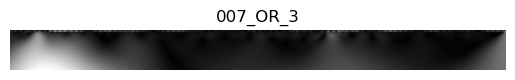

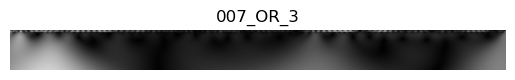

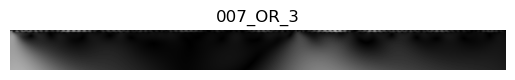

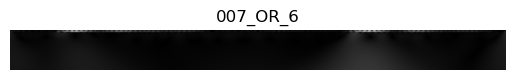

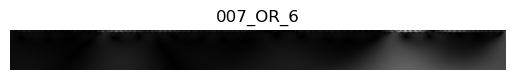

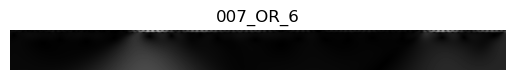

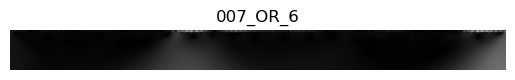

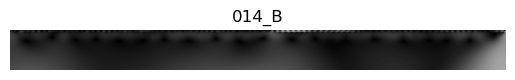

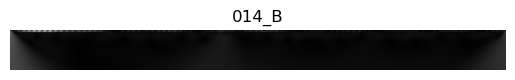

In [28]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [29]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [30]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(X.shape[1],X.shape[2],1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 59, 780, 6)        156       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 390, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 386, 16)       2416      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 193, 16)       0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 37056)             0         
                                                                 
 dense_6 (Dense)             (None, 120)              

In [32]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 236s 6s/step - loss: 1.5375 - accuracy: 0.4656 - val_loss: 0.8228 - val_accuracy: 0.6957
Epoch 2/80
40/40 [==============================] - 224s 6s/step - loss: 0.6586 - accuracy: 0.7462 - val_loss: 0.4915 - val_accuracy: 0.8278
Epoch 3/80
40/40 [==============================] - 233s 6s/step - loss: 0.4240 - accuracy: 0.8464 - val_loss: 0.4406 - val_accuracy: 0.8331
Epoch 4/80
40/40 [==============================] - 224s 6s/step - loss: 0.3221 - accuracy: 0.8859 - val_loss: 0.3002 - val_accuracy: 0.8948
Epoch 5/80
40/40 [==============================] - 224s 6s/step - loss: 0.2876 - accuracy: 0.8949 - val_loss: 0.3157 - val_accuracy: 0.8937
Epoch 6/80
40/40 [==============================] - 220s 6s/step - loss: 0.2271 - accuracy: 0.9212 - val_loss: 0.2604 - val_accuracy: 0.9078
Epoch 7/80
40/40 [==============================] - 218s 5s/step - loss: 0.1925 - accuracy: 0.9324 - val_loss: 0.2391 - val_accuracy: 0.9141
Epoch 8/80
40

213/213 [==============================] - 27s 124ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

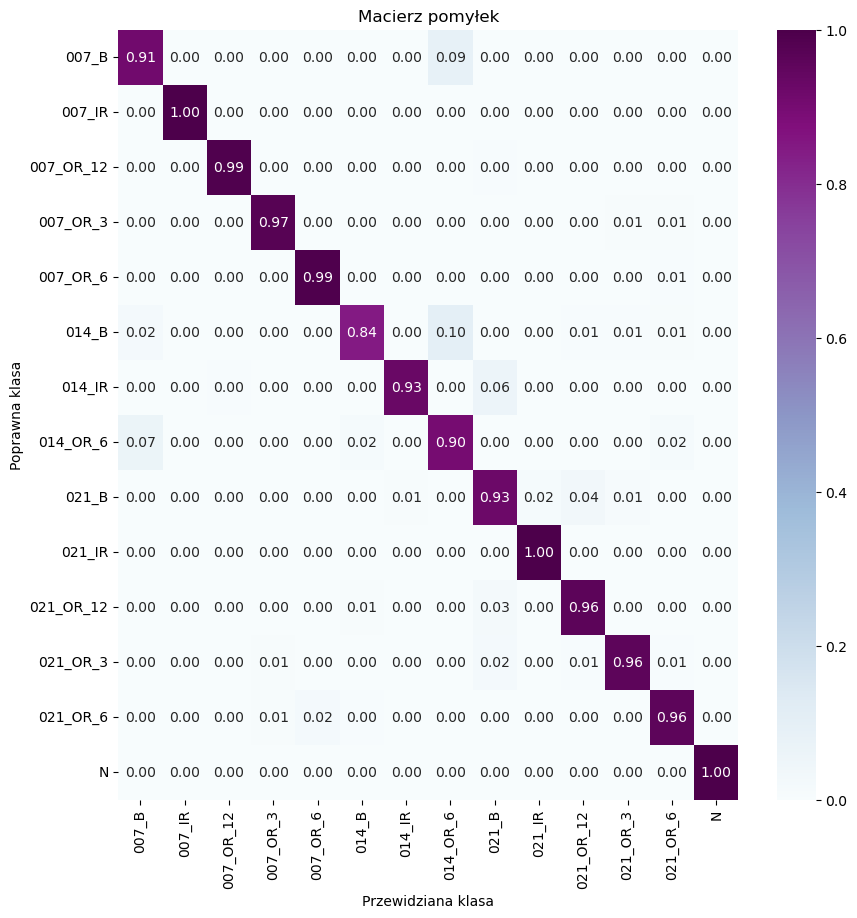

In [33]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [34]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9534371327849589


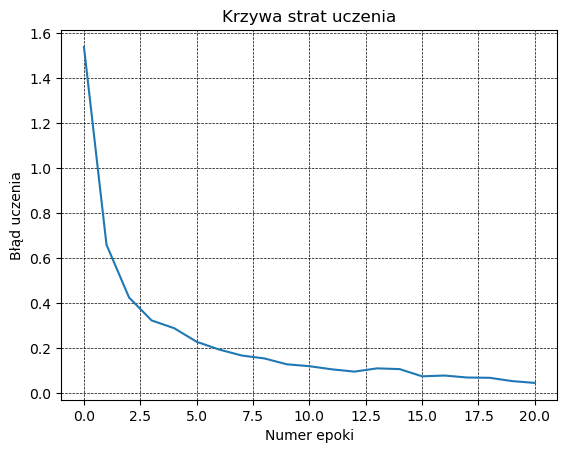

In [35]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

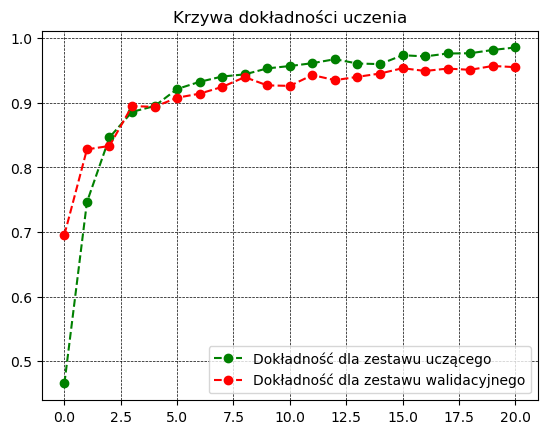

In [36]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

497/497 [==============================] - 62s 124ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15884 samples in 0.000s...
[t-SNE] Computed neighbors for 15884 samples in 1.726s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15884
[t-SNE] Computed conditional probabilities for sample 2000 / 15884
[t-SNE] Computed conditional probabilities for sample 3000 / 15884
[t-SNE] Computed conditional probabilities for sample 4000 / 15884
[t-SNE] Computed conditional probabilities for sample 5000 / 15884
[t-SNE] Computed conditional probabilities for sample 6000 / 15884
[t-SNE] Computed conditional probabilities for sample 7000 / 15884
[t-SNE] Computed conditional probabilities for sample 8000 / 15884
[t-SNE] Computed conditional probabilities for sample 9000 / 15884
[t-SNE] Computed conditional probabilities for sample 10000 / 15884
[t-SNE] Computed conditional probabilities for sample 11000 / 15884
[t-SNE] Computed conditional probabilities for sample 12000

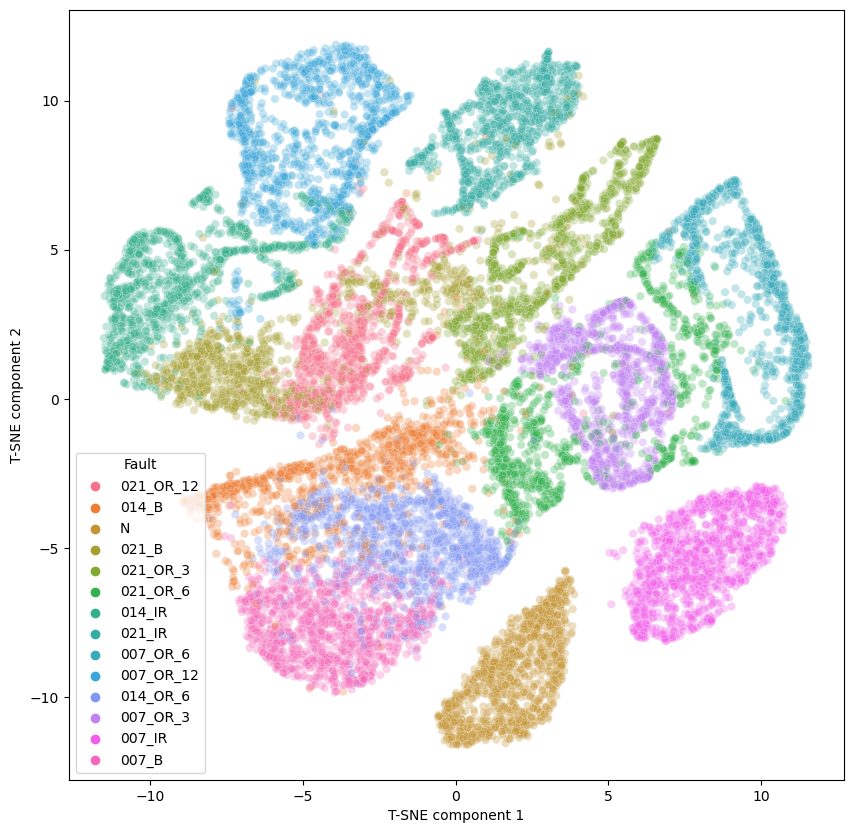

In [37]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [40]:
df = pd.read_csv('3hp_all_faults.csv')

In [41]:
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definicja parametrów
win_len = 784
stride = 300

# Inicjalizacja list dla danych wejściowych (X) i wyjściowych (Y)
X = []
Y = []

# Parametry do transformacji falkowej ciągłej (CWT)
widths = np.arange(1, 64) # Zakres skali
wavelet = morlet # Wybrana falka Morleta

# Pętla przez unikalne etykiety w kolumnie 'fault' ramki danych df
for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k] # Wybór wierszy odpowiadających danej etykiecie

    # Pętla przez ramkę danych z krokiem określonym przez parametr stride
    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values # Wybór okna danych
        temp = np.sum(temp, axis=1) # Sumowanie danych wzdłuż osi, pozostawiając jednowymiarowy sygnał
        
        # Przeprowadzenie CWT na każdej próbce
        cwt_data = cwt(temp, wavelet, widths)
        
        # Dostosowanie kształtu danych
        cwt_data = np.abs(cwt_data)

        X.append(cwt_data) # Dodanie danych wejściowych do listy X
        Y.append(df_temp_2.iloc[i + win_len, -1]) # Dodanie etykiety do listy Y

# Konwersja list X i Y na tablice numpy
X = np.array(X)
Y = np.array(Y)

# Kodowanie etykiet klas za pomocą LabelEncodera i przekształcenie ich na postać one-hot
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

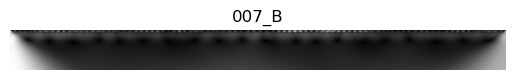

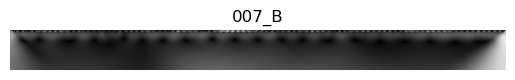

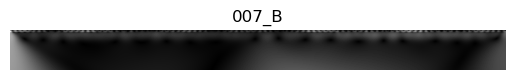

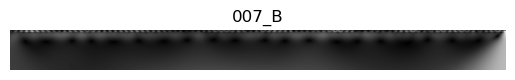

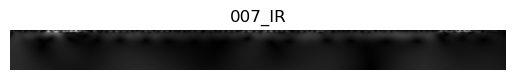

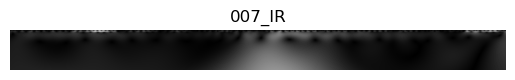

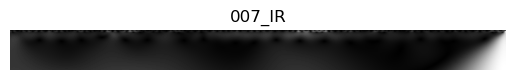

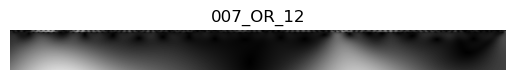

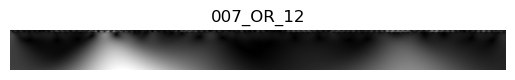

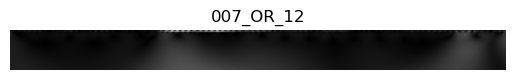

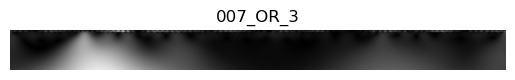

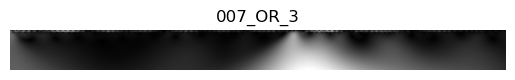

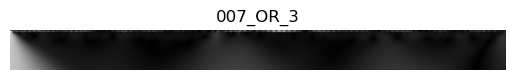

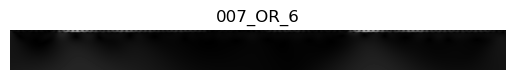

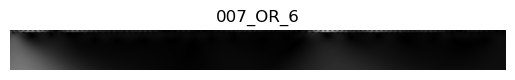

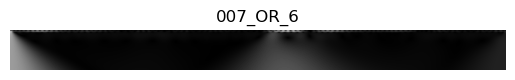

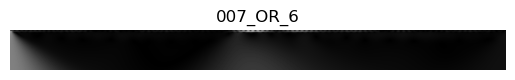

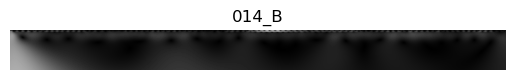

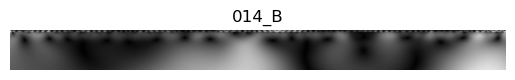

In [42]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [43]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [44]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(6, kernel_size=(5, 5), activation='relu',  input_shape=(X.shape[1],X.shape[2],1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(16, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 59, 780, 6)        156       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 29, 390, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 386, 16)       2416      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 12, 193, 16)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 37056)             0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [46]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 224s 6s/step - loss: 1.6139 - accuracy: 0.4384 - val_loss: 0.8381 - val_accuracy: 0.6978
Epoch 2/80
40/40 [==============================] - 216s 5s/step - loss: 0.6365 - accuracy: 0.7715 - val_loss: 0.5762 - val_accuracy: 0.7852
Epoch 3/80
40/40 [==============================] - 219s 5s/step - loss: 0.4248 - accuracy: 0.8487 - val_loss: 0.4058 - val_accuracy: 0.8560
Epoch 4/80
40/40 [==============================] - 218s 5s/step - loss: 0.3124 - accuracy: 0.8938 - val_loss: 0.3235 - val_accuracy: 0.8822
Epoch 5/80
40/40 [==============================] - 224s 6s/step - loss: 0.2523 - accuracy: 0.9142 - val_loss: 0.2700 - val_accuracy: 0.9095
Epoch 6/80
40/40 [==============================] - 223s 6s/step - loss: 0.2076 - accuracy: 0.9311 - val_loss: 0.2673 - val_accuracy: 0.9060
Epoch 7/80
40/40 [==============================] - 223s 6s/step - loss: 0.1889 - accuracy: 0.9365 - val_loss: 0.2203 - val_accuracy: 0.9296
Epoch 8/80
40

213/213 [==============================] - 24s 111ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

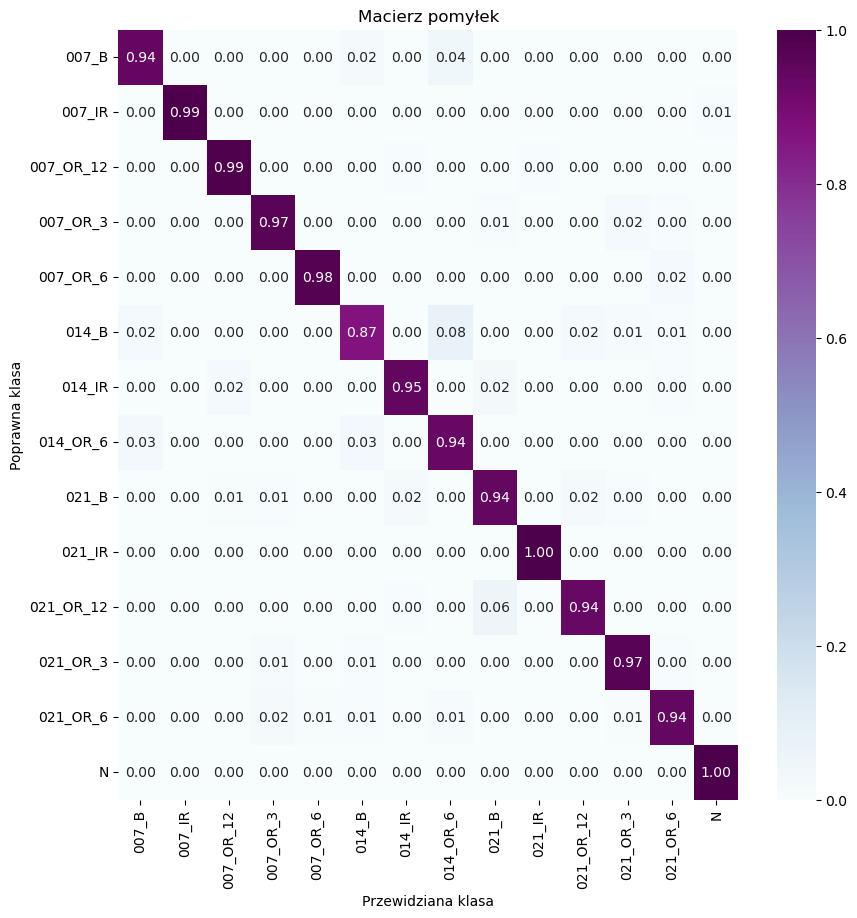

In [47]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [48]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9581313353900397


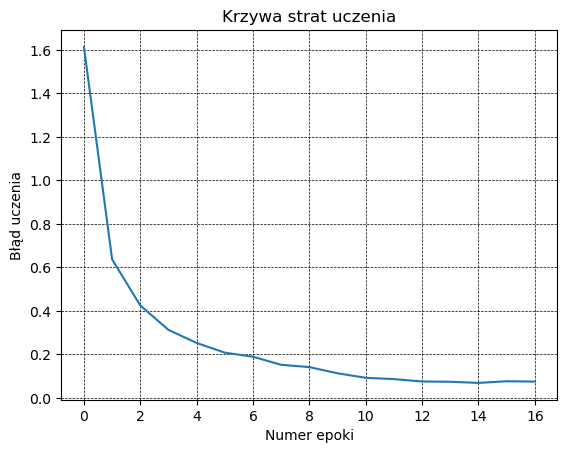

In [49]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

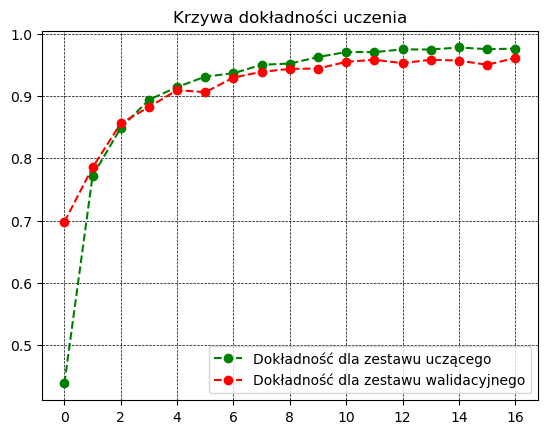

In [50]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

497/497 [==============================] - 71s 141ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15880 samples in 0.005s...
[t-SNE] Computed neighbors for 15880 samples in 1.906s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15880
[t-SNE] Computed conditional probabilities for sample 2000 / 15880
[t-SNE] Computed conditional probabilities for sample 3000 / 15880
[t-SNE] Computed conditional probabilities for sample 4000 / 15880
[t-SNE] Computed conditional probabilities for sample 5000 / 15880
[t-SNE] Computed conditional probabilities for sample 6000 / 15880
[t-SNE] Computed conditional probabilities for sample 7000 / 15880
[t-SNE] Computed conditional probabilities for sample 8000 / 15880
[t-SNE] Computed conditional probabilities for sample 9000 / 15880
[t-SNE] Computed conditional probabilities for sample 10000 / 15880
[t-SNE] Computed conditional probabilities for sample 11000 / 15880
[t-SNE] Computed conditional probabilities for sample 12000

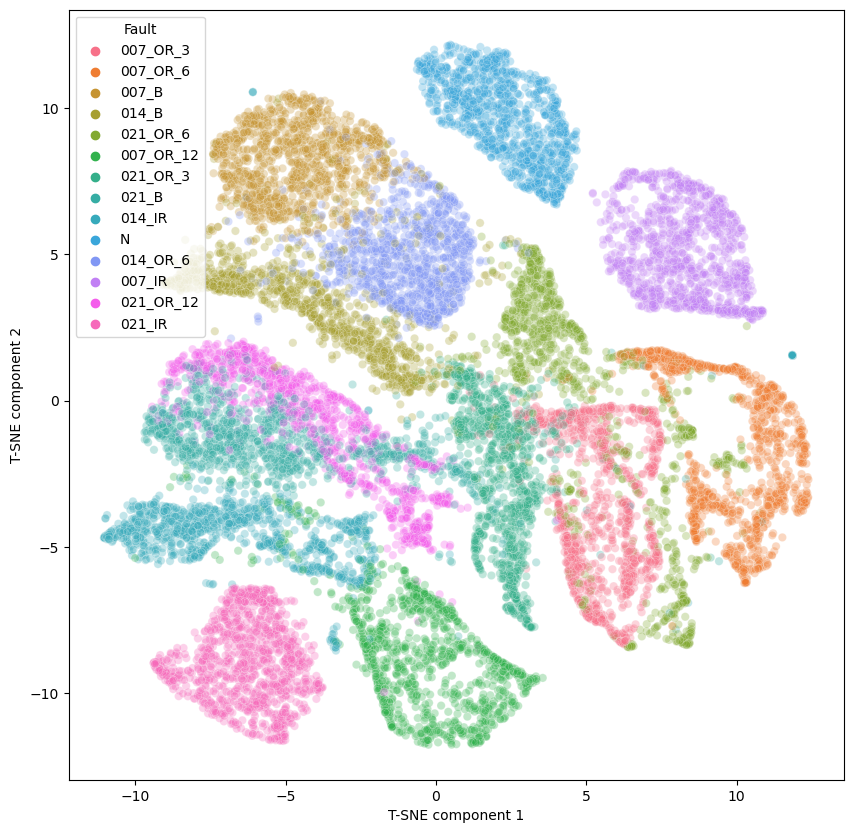

In [51]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

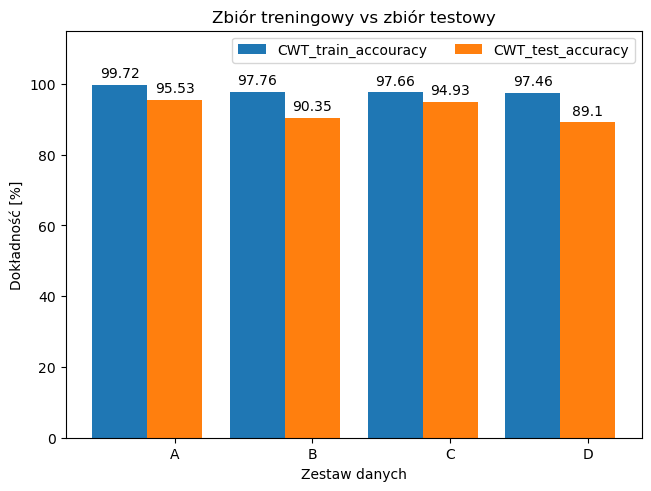

In [52]:
# Definiowanie danych
CWT_train_accouracy = [99.72, 97.76, 97.66 , 97.46 ]
CWT_test_accuracy = [95.53, 90.35, 94.93, 89.10 ]

models = ('A', 'B', 'C', 'D')    
CWT_data = {
'CWT_train_accouracy' : (99.72, 97.76, 97.66 , 97.46),
'CWT_test_accuracy' : (95.53, 90.35, 94.93, 89.10),
}

# Przygotowanie danych do wykresu   
x = np.arange(len(models))
width = 0.4
multiplier = 0

# Tworzenie wykresu
fig, ax = plt.subplots(layout = 'constrained')
for attribute, measurement in CWT_data.items():
    offset = width * multiplier
    rects= ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    
# Ustawienia osi i legendy           
ax.set_ylabel('Dokładność [%]')
ax.set_xlabel('Zestaw danych')
ax.set_title('Zbiór treningowy vs zbiór testowy')
ax.set_xticks(x + width, models)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 115)
plt.show()